In [496]:
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns


In [497]:
df = yf.download('AAPL', '2018-01-01', '2023-01-01')
df.info()

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2018-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1259 non-null   float64
 1   (High, AAPL)    1259 non-null   float64
 2   (Low, AAPL)     1259 non-null   float64
 3   (Open, AAPL)    1259 non-null   float64
 4   (Volume, AAPL)  1259 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 59.0 KB


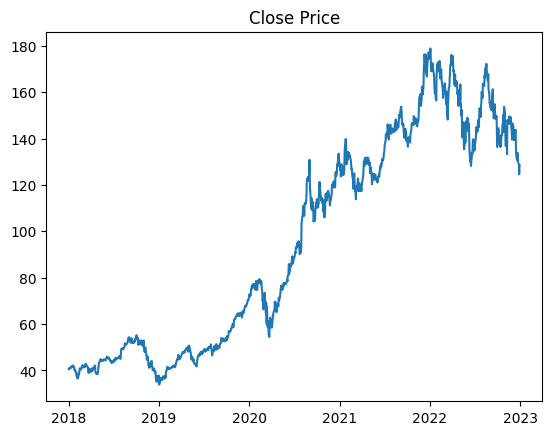

In [498]:
plt.title("Close Price")
plt.plot(df.Close)

Text(0.5, 1.0, 'Covid Era')

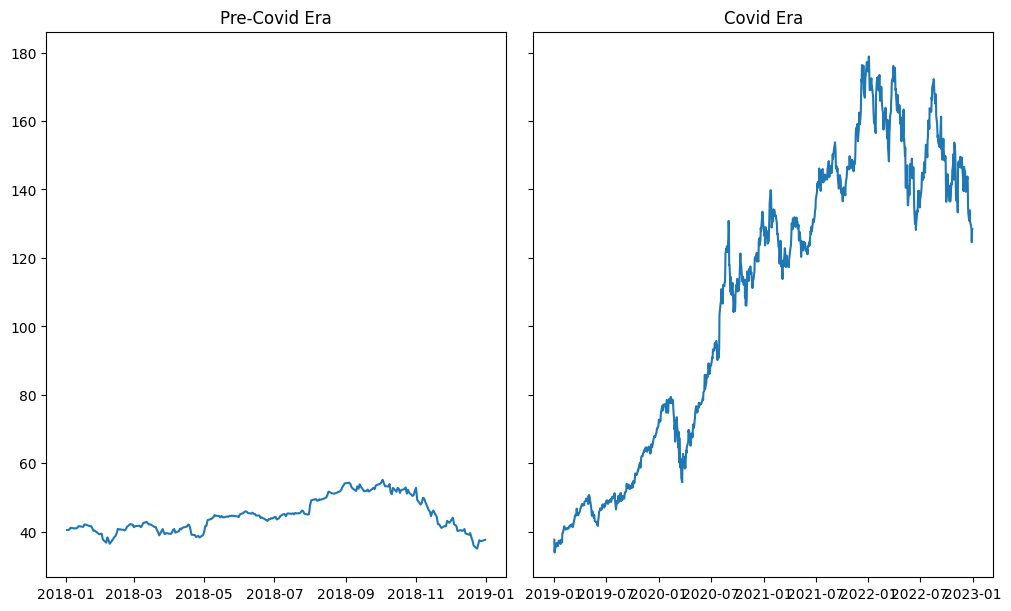

In [499]:
fig, ax = plt.subplots(1, 2, figsize=(10,6),  layout = 'constrained', sharey = True)

ax[0].plot(df.loc['2018' : '2018', 'Close'])
ax[0].set_title("Pre-Covid Era")

ax[1].plot(df.loc['2019' : '2022', 'Close'])
ax[1].set_title("Covid Era")


In [500]:
print(df.describe())

Price         Close         High          Low         Open        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   1259.000000  1259.000000  1259.000000  1259.000000  1.259000e+03
mean      95.702890    96.801484    94.519861    95.640170  1.168806e+08
std       46.139145    46.720912    45.520935    46.131170  5.504461e+07
min       33.915264    34.757242    33.869945    34.342215  3.519590e+07
25%       48.939260    49.328002    48.508398    48.946825  8.014245e+07
50%       89.189941    90.491773    88.486683    88.846815  1.023002e+08
75%      140.533104   141.942101   138.793261   140.569230  1.372052e+08
max      178.879913   179.793936   176.039622   179.489269  4.265100e+08


In [501]:
df.reset_index(inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        1259 non-null   datetime64[ns]
 1   (Close, AAPL)   1259 non-null   float64       
 2   (High, AAPL)    1259 non-null   float64       
 3   (Low, AAPL)     1259 non-null   float64       
 4   (Open, AAPL)    1259 non-null   float64       
 5   (Volume, AAPL)  1259 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 59.1 KB
None


In [502]:
df['ma5'] = df.Close.rolling(window=5).mean()
df['ma10'] = df.Close.rolling(window=10).mean()
df['ma50'] = df.Close.rolling(window=50).mean()
df['close_shifted'] = df.Close.shift(1)
df.dropna(inplace=True)
df


Price,Date,Close,High,Low,Open,Volume,ma5,ma10,ma50,close_shifted
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,,,,
49,2018-03-14,42.103065,42.593844,41.954415,42.546654,117473600,42.331928,41.923261,40.570717,42.464046
50,2018-03-15,42.152611,42.527775,42.015762,42.117220,90975200,42.412624,42.009384,40.604172,42.103065
51,2018-03-16,42.003956,42.263500,41.909573,42.152602,157618800,42.320132,42.052090,40.634795,42.152611
52,2018-03-19,41.362164,41.874176,40.975204,41.838785,133787200,42.017168,42.016225,40.648823,42.003956
53,2018-03-20,41.348015,41.716097,41.277229,41.348015,78597600,41.793962,41.982485,40.653309,41.362164
...,...,...,...,...,...,...,...,...,...,...
1254,2022-12-23,130.344482,130.898044,128.149997,129.415284,63814900,131.315204,135.266264,142.403257,130.710251
1255,2022-12-27,128.535507,129.899651,127.240566,129.869997,69007800,130.852579,133.836884,142.242707,130.344482
1256,2022-12-28,124.591377,129.524023,124.423333,128.179654,85438400,129.614964,131.916215,141.923732,128.535507


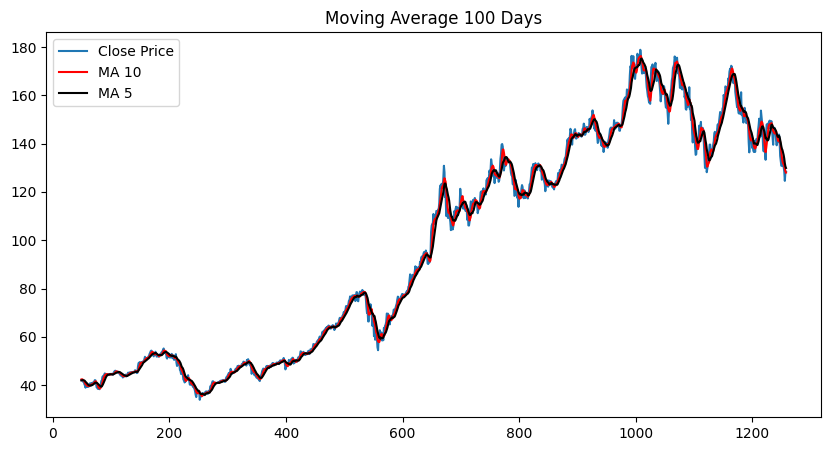

In [503]:
plt.figure(figsize=(10,5))
plt.title("Moving Average 100 Days")
plt.plot(df.Close, label="Close Price")
plt.plot(df.ma5, color='red', label="MA 10")
plt.plot(df.ma10, color='black', label="MA 5")

plt.legend()
plt.show()

In [504]:
def calculate_rsi(df, window=14):
    delta = df.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [505]:
df['rsi'] = calculate_rsi(df.Close).dropna()
df['day_of_week'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['high_low_ratio'] = df['High'] / df['Low']
df['return_1d'] = df['Close'].pct_change()  # Variation journalière en %
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))  # Log-rendement
df = df.iloc[14:].reset_index(drop=True)
df

Price,Date,Close,High,Low,Open,Volume,ma5,ma10,ma50,close_shifted,rsi,day_of_week,month,high_low_ratio,return_1d,log_return
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,,,
0,2018-04-04,40.491516,40.585895,38.877614,38.903568,138422000,39.684090,39.807492,40.317921,39.731747,40.344965,2,4,1.043940,0.019122,0.018942
1,2018-04-05,40.772285,41.109693,40.602401,40.720376,107732800,39.982331,39.843591,40.301304,40.491516,41.953207,3,4,1.012494,0.006934,0.006910
2,2018-04-06,39.729393,40.696789,39.686920,40.340505,140021200,40.010643,39.832502,40.277084,40.772285,37.992092,4,4,1.025446,-0.025578,-0.025911
3,2018-04-09,40.123428,40.840717,40.076239,40.083317,116070800,40.169674,39.953073,40.275360,39.729393,43.284785,0,4,1.019076,0.009918,0.009869
4,2018-04-10,40.878471,41.055434,40.472636,40.819484,113634400,40.399019,39.964398,40.286858,40.123428,47.643857,1,4,1.014400,0.018818,0.018643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,2022-12-23,130.344482,130.898044,128.149997,129.415284,63814900,131.315204,135.266264,142.403257,130.710251,26.261520,4,12,1.021444,-0.002798,-0.002802
1192,2022-12-27,128.535507,129.899651,127.240566,129.869997,69007800,130.852579,133.836884,142.242707,130.344482,27.960189,1,12,1.020898,-0.013878,-0.013976
1193,2022-12-28,124.591377,129.524023,124.423333,128.179654,85438400,129.614964,131.916215,141.923732,128.535507,26.152253,2,12,1.040995,-0.030685,-0.031166


In [506]:
features = ['ma5', 'close_shifted', 'day_of_week', 'month', 'high_low_ratio', 'rsi', 'ma5', 'ma10', 'ma50', 'return_1d', 'log_return']
target = ['Close']
df = df.set_index(df['Date'])

In [507]:
# Calcul de la taille de l'ensemble d'entraînement
train_size = int(len(df) * 0.8)  # Conversion en entier

# Sélection des colonnes (correction syntaxique)
df_model = df[features]

x_train = df_model[:train_size].to_numpy()
y_train = df.Close[:train_size].to_numpy()
x_test = df_model[train_size:].to_numpy()
y_test = df.Close[train_size:].to_numpy()


print(x_test.shape)  # Afficher la taille de x_test
print(y_test.shape)  # Afficher la taille de y_test


(240, 11)
(240, 1)


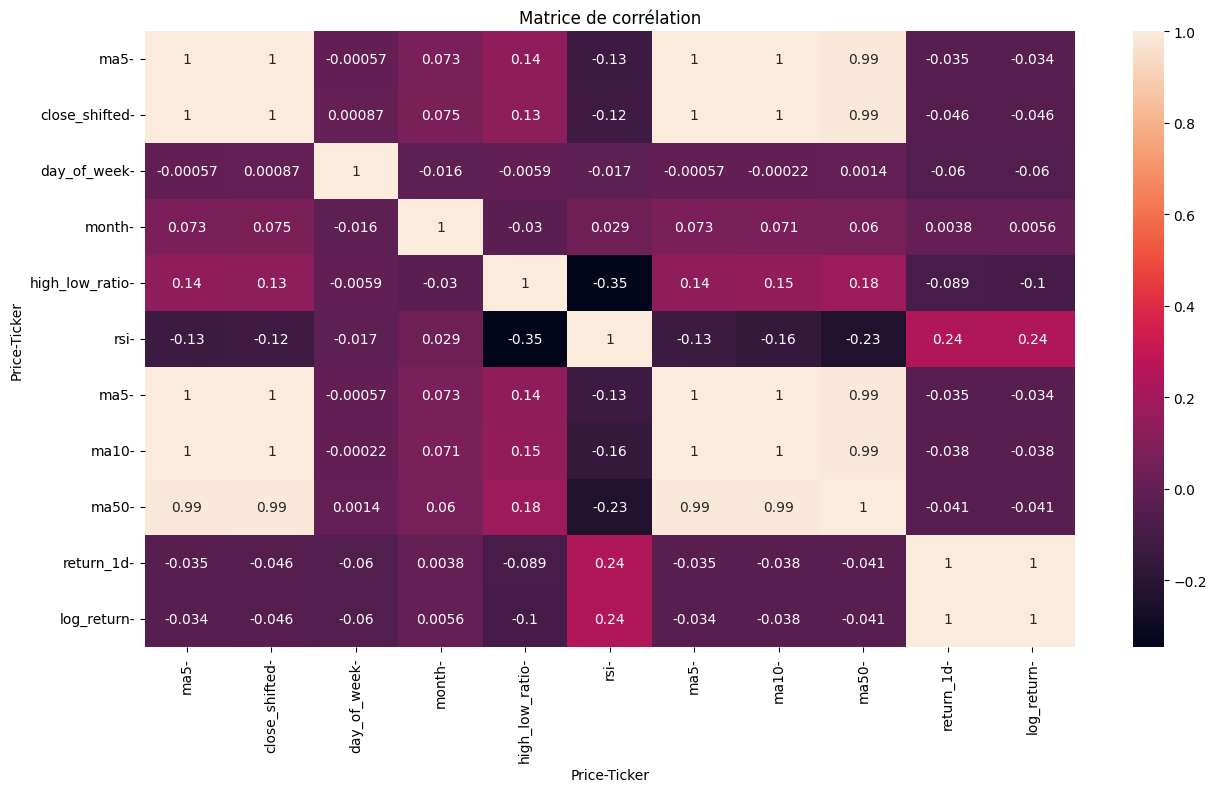

In [508]:
plt.figure(figsize=(15,8))
sns.heatmap(df_model.corr(), annot=True)
plt.title("Matrice de corrélation")
plt.show()

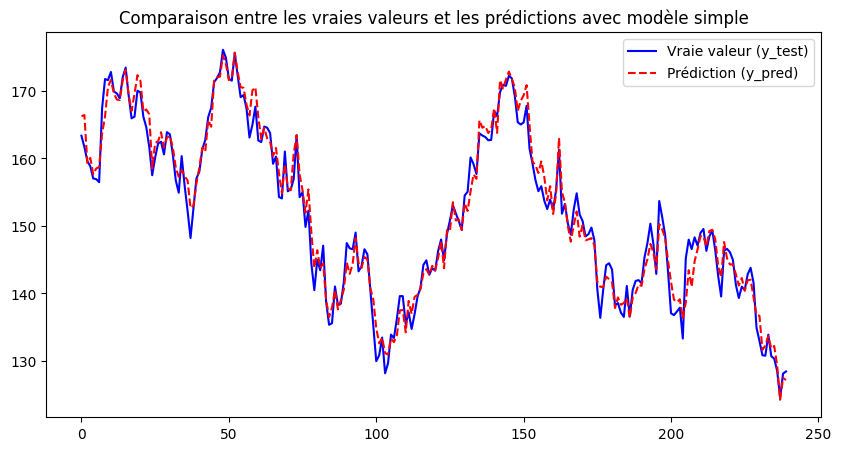

In [509]:
xgb_simple = XGBRegressor(
    max_depth=3, 
    learning_rate=0.1, 
    n_estimators=200, 
    subsample=0.8, 
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
)
xgb_simple.fit(x_train, y_train)

# Prédictions
y_pred_simple = xgb_simple.predict(x_test)

# Visualisation
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Vraie valeur (y_test)", color='blue')
plt.plot(y_pred_simple, label="Prédiction (y_pred)", color='red', linestyle='dashed')
plt.legend()
plt.title("Comparaison entre les vraies valeurs et les prédictions avec modèle simple")
plt.show()


In [510]:
mse = mean_squared_error(y_test, y_pred_simple)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_simple)

mse, rmse, mae

(4.272451722925568, 2.066990982787677, 1.6018950780232748)

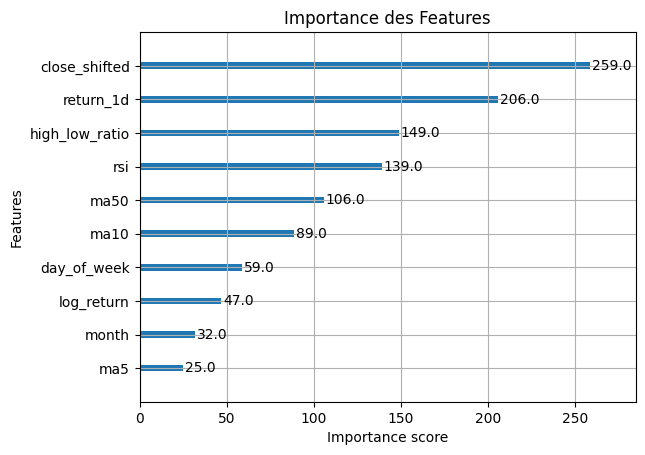

In [516]:
# Associe les noms des features au modèle XGBoost
xgb_simple.get_booster().feature_names = features

# Tracer l'importance des features avec les bons noms
xgb.plot_importance(xgb_simple, importance_type='weight', max_num_features=11)
plt.title("Importance des Features")
plt.show()

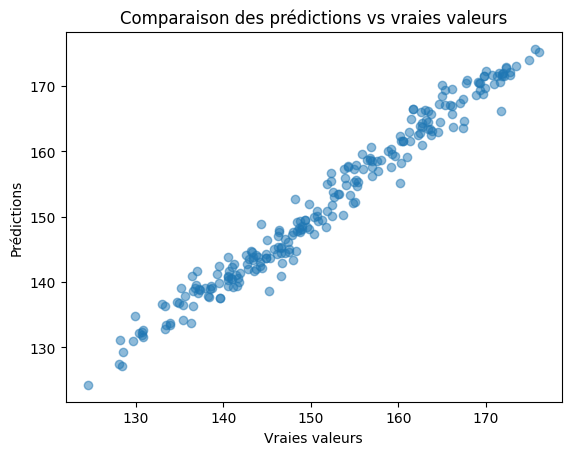

In [ ]:
plt.scatter(y_test, y_pred_simple, alpha=0.5)
plt.xlabel("Vraies valeurs")
plt.ylabel("Prédictions")
plt.title("Comparaison des prédictions vs vraies valeurs")
plt.show()
